In [1]:
outdir = '/tigress/changgoo/public_html/TIGRESS-NCR/lowZ-figures/'

In [2]:
Y0=dict(th=414.,turb=615.,mag=481.,nonth=1.23e3)
s1=dict(th=-0.46,turb=-0.22,mag=-0.38,nonth=-0.22)
s2=dict(th=-0.50,turb=0.0,mag=-0.54,nonth=-0.15)

In [3]:
import numpy as np
Z=np.logspace(-2,1,300)
W=np.logspace(1,7,600)

In [4]:
import xarray as xr
Y=xr.Dataset()

In [9]:
Z0=0.1
p=0
for c in Y0:
    Yfit = Y0[c]*(W[:,np.newaxis]/1.e4)**s1[c]*Z[np.newaxis,:]**s2[c]
    if p>0: Yfit *= (1+(Z0/Z[np.newaxis,:])**p)**(s2[c]/p)
    Y[c] = xr.DataArray(Yfit,
                        coords=[W,Z],dims=['W','Z'])

Y['tot'] = Y['th'] + Y['nonth']

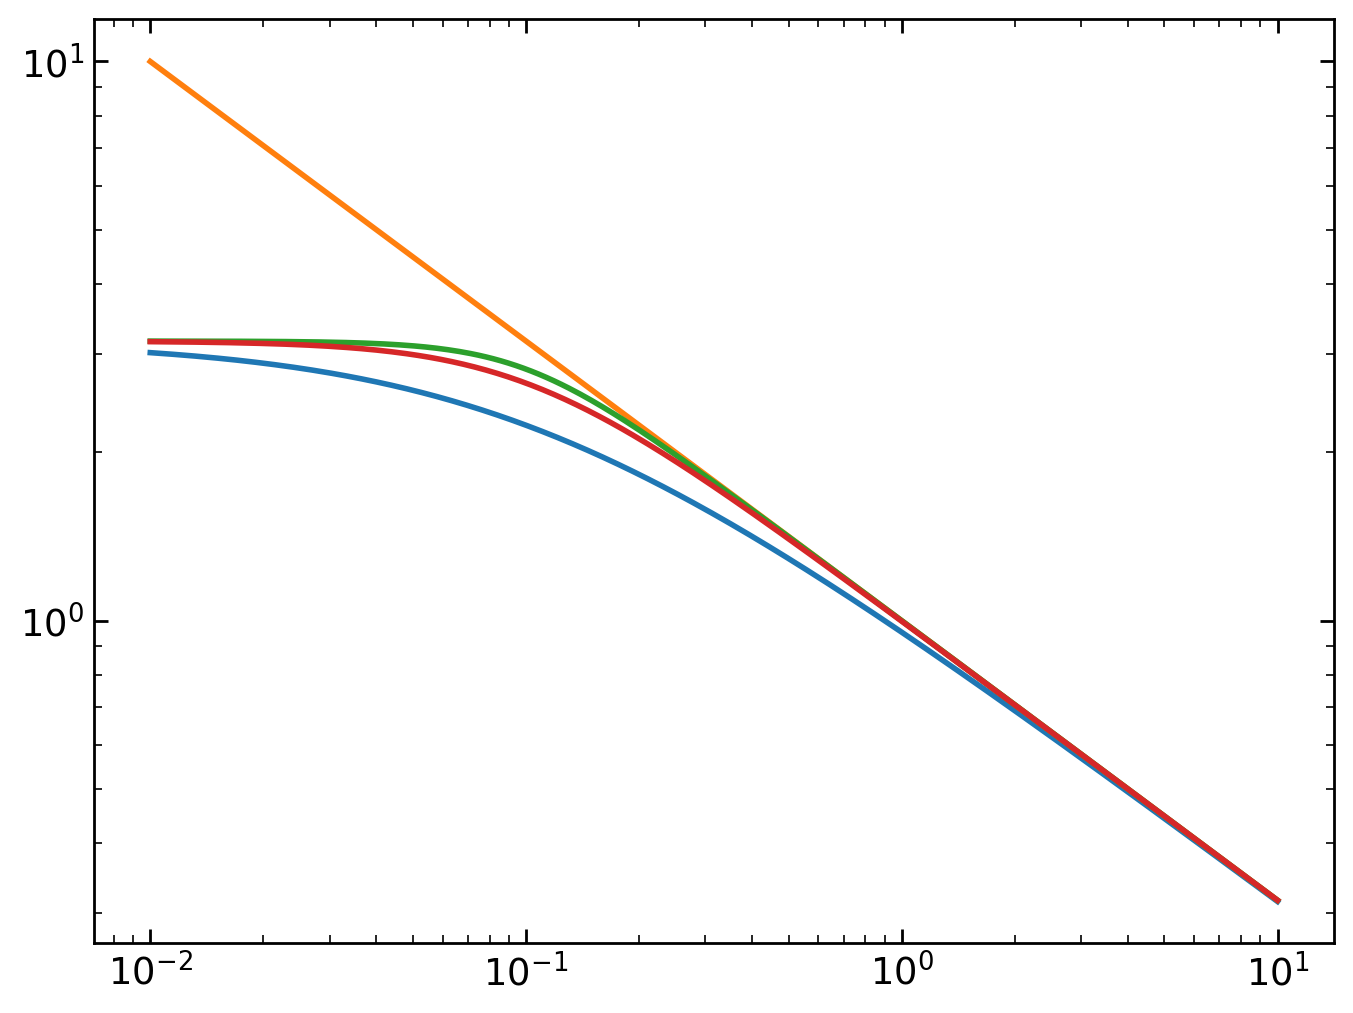

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ncr-paper.mplstyle')
plt.rcParams['axes.grid']=False

plt.plot(Z,(Z+0.1)**s2['th'])
plt.plot(Z,(Z)**s2['th'])
plt.plot(Z,(Z**3+0.1**3)**(s2['th']/3))
plt.plot(Z,(Z**2+0.1**2)**(s2['th']/2))
plt.yscale('log')
plt.xscale('log')

In [10]:
# calculate critical weight at Yth/Ynonth = 1,3,10
f = np.array([1,3,10])
f0 = (Y0['th']/Y0['nonth']*f)**(1/0.24)
print(f0)
print("slope:",-0.35/0.24)

# power in smoothing function
factor = 1
if p>0: factor = (1+(0.1/Y.Z)**p)**(-1.46/p)
Wcrit = [f0_*1.e4*Y.Z**(-1.46)*factor for f0_ in f0]

[1.07044278e-02 1.04128278e+00 1.57119513e+02]
slope: -1.4583333333333333


In [17]:
Wcrit[0].interp(Z=0.1)

<xarray.DataArray 'Z' ()>
array(3087.85160276)
Coordinates:
    Z        float64 0.1

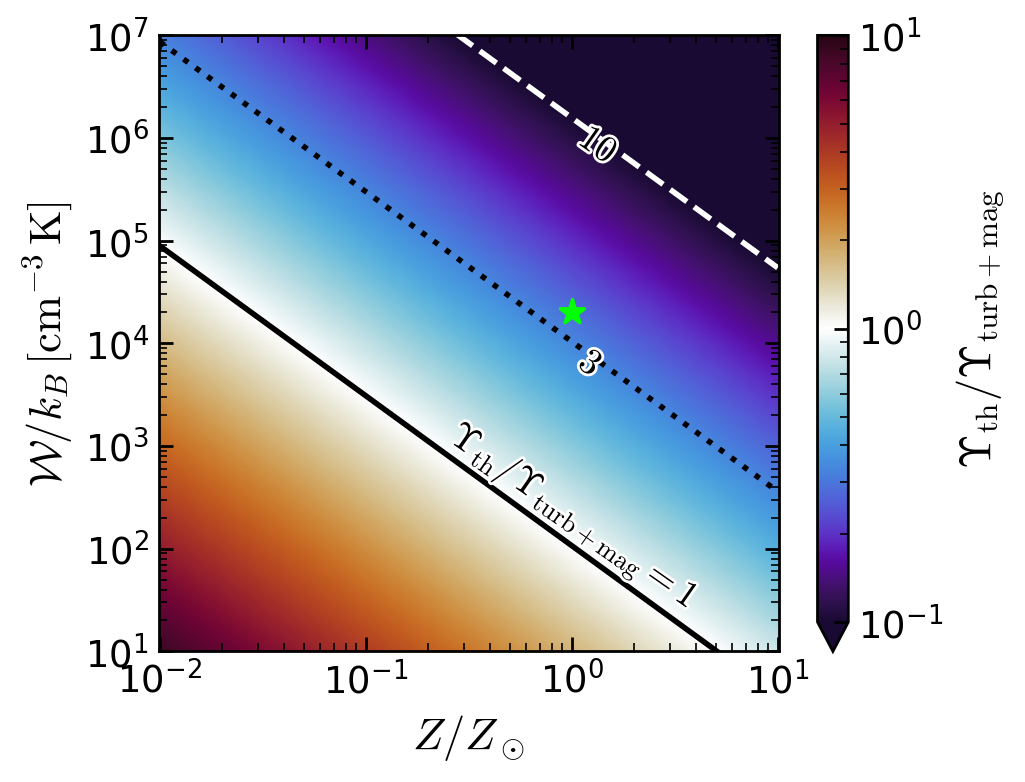

In [11]:
from matplotlib.patheffects import withStroke
import cmasher as cmr

plt.figure(figsize=(5,4))
plt.pcolormesh(Y.Z,Y.W,(Y['th']/Y['nonth']),cmap=cmr.fusion_r,norm=LogNorm(0.1,10))
# plt.plot(Y.Z,Wcrit,ls=':')
plt.plot(Y.Z,Wcrit[0],ls='-',color='k')
plt.plot(Y.Z,Wcrit[1],ls=':',color='k')
plt.plot(Y.Z,Wcrit[2],ls='--',color='w')
plt.annotate(r'$\Upsilon_{\rm th}/\Upsilon_{\rm turb+mag} = 1$',(1,2.e2),
             rotation=-35,ha='center',va='center',fontsize='small',
             path_effects=[withStroke(foreground='w',linewidth=2)])
plt.annotate(#r'$3\Upsilon_{\rm th} = \Upsilon_{\rm turb+mag}$',
             '$3$',(1,1.e4),
             rotation=-35,ha='left',va='top',fontsize='small',
             path_effects=[withStroke(foreground='w',linewidth=2)])
plt.annotate(#r'$3\Upsilon_{\rm th} = \Upsilon_{\rm turb+mag}$',
             '$10$',(1,1.5e6),
             rotation=-35,ha='left',va='top',fontsize='small',
             path_effects=[withStroke(foreground='w',linewidth=2)])
plt.plot(1,2.e4,'*',color='lime',markersize=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$Z/Z_\odot$')
plt.ylabel(r'$\mathcal{W}/k_B\,[{\rm cm^{-3}\,K}]$')
plt.colorbar(label=r'$\Upsilon_{\rm th} / \Upsilon_{\rm turb+mag}$',
            extend='min')
plt.ylim(1.e1,1.e7)
plt.savefig(os.path.join(outdir,'Wcrit.png'),bbox_inches='tight')

In [21]:
for W_ in Wlist:
    yval = Y['tot'].interp(W=W_,Z=0.1)/Y['tot'].interp(W=W_,Z=1)
    print(W_,yval.data)

10.0 2.5298005217308175
100.0 2.2945758594784156
1000.0 2.0583077404976966
10000.0 1.8531858448283118
100000.0 1.6964604800306313
1000000.0 1.5880050678168942
10000000.0 1.5179971996454886


In [22]:
0.1**0.5

0.31622776601683794

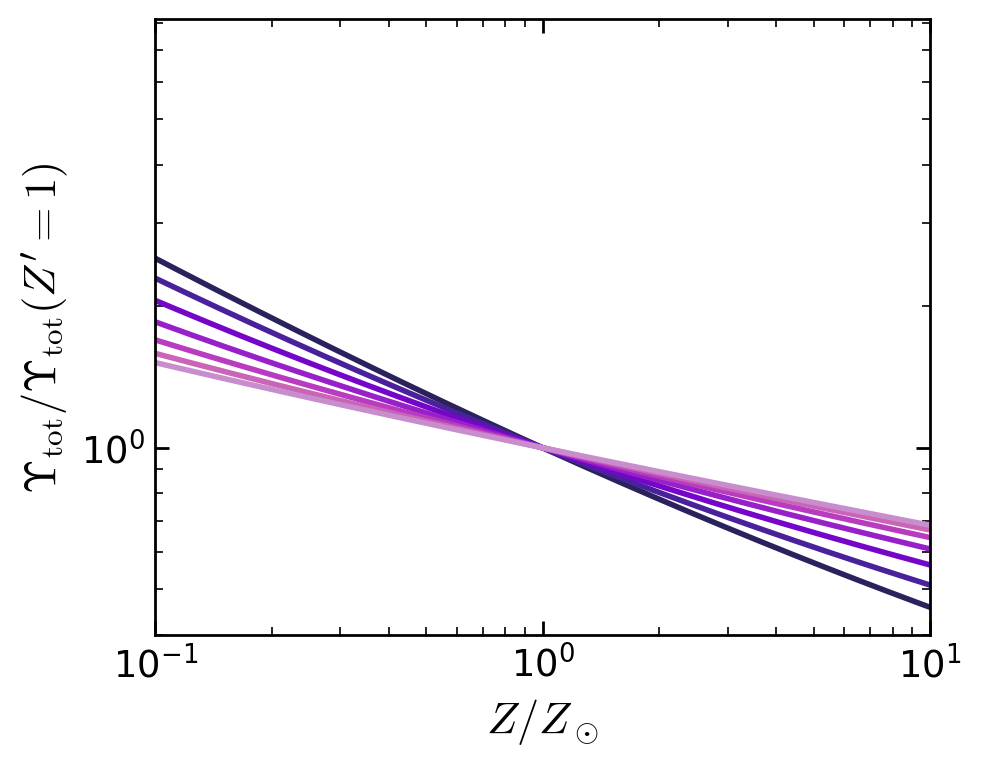

In [14]:
plt.figure(figsize=(5,4))
Wlist = [1.e1,1.e2,1.e3,1.e4,1.e5,1.e6,1.e7]
clist = cmr.get_sub_cmap('cmr.gothic',0.2,0.7,N=len(Wlist)).colors
for W_,c_ in zip(Wlist,clist):
    yval = Y['tot'].interp(W=W_)/Y['tot'].interp(W=W_,Z=1)
    plt.plot(Y.Z,yval,color=c_)
    exp = int(np.log10(W_/1.e4))
    if exp in [-3,0,3]:
        tt = f'$\\log\\mathcal{{W_4}} =$' if W_==1.e4 else ''
        tt += f'${exp}$'
        plt.annotate(tt,(0.04,yval.data.max()*0.98),
                     fontsize='x-small',color=c_,
                     ha='right',va='bottom' if W_<1.e7 else 'top',
                    path_effects=[withStroke(foreground='w',linewidth=1)])
plt.xlim(0.1,10)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\Upsilon_{\rm tot}/\Upsilon_{\rm tot}(Z^\prime=1)$')
plt.xlabel(r'$Z/Z_\odot$')
plt.savefig(os.path.join(outdir,'Ytot_Z.png'),bbox_inches='tight')

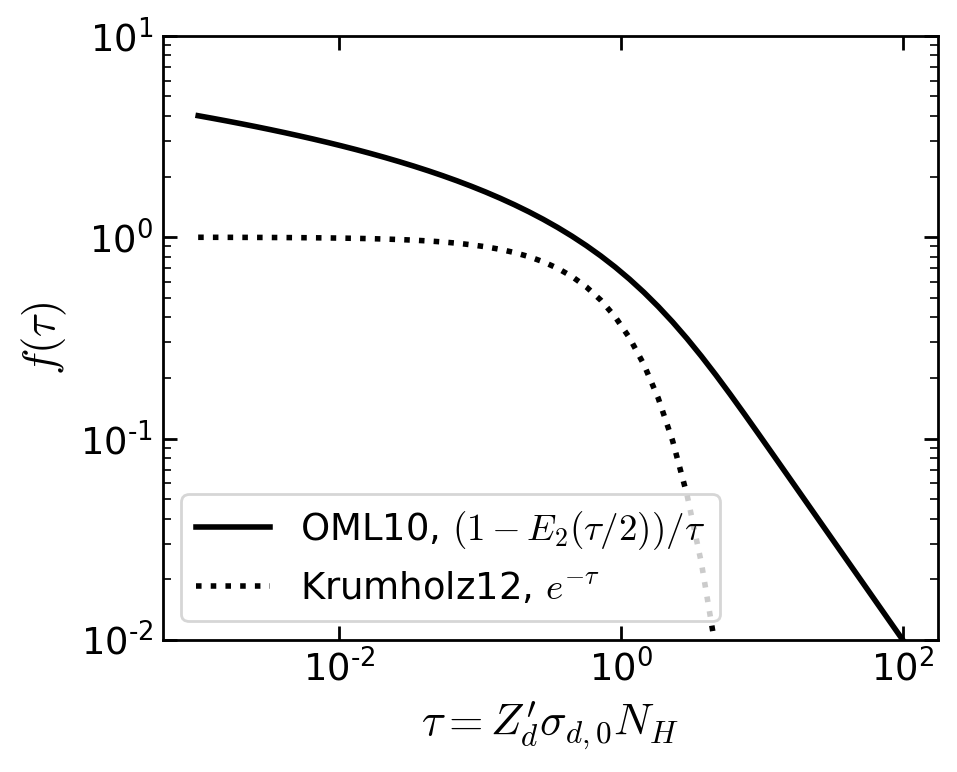

In [42]:
import scipy.special as sc
fig=plt.figure(figsize=(5,4))
tau = np.logspace(-3,2)
ftau = (1-sc.expn(2,tau/2))/tau
plt.loglog(tau,ftau,'k',label=r'OML10, $(1-E_2(\tau/2))/\tau$')
plt.plot(tau,np.exp(-tau),'k',ls=':',label=r'Krumholz12, $e^{-\tau}$')
plt.ylim(1.e-2,1.e1)
plt.xlabel(r'$\tau = Z_d^\prime\sigma_{d,0} N_H$')
plt.ylabel(r'$f(\tau)$')
plt.legend()